##### Configuración

In [111]:
## Celda de configuración

# Librerias
import random
import time
import sys
import os

# Instancias y algoritmos
sys.path.append(os.path.abspath("../Instances"))
from InsKnapsack import generar_datos, visualizar, report

# Programación Dinámica
sys.path.append(os.path.abspath("../DP/Env"))         # entorno del problema
sys.path.append(os.path.abspath("../DP/Algorithms/")) # algoritmos RL / DP
sys.path.append(os.path.abspath("../DP/Visual/"))     # visualización de políticas / valores

from Knapsack import KnapsackEnv  # Clase que define el entorno tipo mochila

from value_iteration import value_iteration           # iteración de valores
from policy_evaluation import policy_evaluation       # evaluación de políticas
from policy_iteration import policy_iteration         # iteración de políticas

from value_states import value_states_visual          # visualización de V(s)
from policy_dag import draw_policy_dag                # grafo de política óptima

# MinObras

El Ministerio de Transporte (MinTransporte) cuenta con un presupuesto de **100 millones de pesos** para ejecutar obras de infraestructura vial, con el fin de generar desarrollo en Bogotá. D.C.

MinTransporte le va a proporcionar datos que contiene información sobre:

- **Costo de ejecución** de cada proyecto (en millones de pesos)
- **Número de empleos generados** (en miles)
- **Ubicación geográfica** del proyecto (latitud y longitud)

El objetivo del Ministerio es **maximizar la cantidad total de empleos generados**, respetando el límite presupuestal.

In [ ]:
# 1. TODO Defina el número de obras a usar.
NUM_OBRAS = 25

# ----- DESDE ACÁ EN ADELANTE, NO TOQUE EL CÓDIGO DE ESTÁ CELDA.
# . Generar Obras.
obras = generar_datos(NUM_OBRAS)
visualizar(obras)

# . Guardar resultados.
resultados = []

## Optimización (MIP)

### Formulación

#### 1. Conjuntos  
$O$: conjunto de obras disponibles.

#### 2. Parámetros  
$c_i$: costo de ejecución (en millones de pesos) de la obra $i \in O$  
$e_i$: empleos generados (en miles) por la realización de la obra $i \in O$  
$p$: presupuesto total disponible (en millones de pesos)

#### 3. Variables de decisión  
$$
x_i =
\begin{cases}
1, & \text{si la obra } i \in O \text{ se lleva a cabo} \\
0, & \text{en caso contrario}
\end{cases}
$$

#### 4. Función objetivo  
Maximizar el total de empleos generados:
$$
\max \sum_{i \in O} e_i \cdot x_i
$$

#### 5. Restricciones  

**(1) Presupuesto disponible:**  
$$
\sum_{i \in O} c_i \cdot x_i \leq p
$$

**(2) Naturaleza de las variables:**  
$$
x_i \in \{0, 1\}, \quad \forall i \in O
$$

Donde:

- La restricción (1) garantiza que no se exceda el presupuesto disponible.  
- La restricción (2) establece la naturaleza binaria de las variables de decisión.


In [ ]:
# 2. TODO Extraiga los parámetros relevantes desde el DataFrame 'obras' para
# construir los insumos del modelo:
#   • Conjunto de decisiones
#   • Costos (c)
#   • Beneficios (empleos generados, e)
#   • Presupuesto total disponible

# Conjuntos
O = list(obras.index)

# Parámetros
c = dict(obras['Costo de ejecución (en millones de pesos)'])
e = dict(obras['# de empleos generados (en miles)'])

# ----- DESDE ACÁ EN ADELANTE, NO TOQUE EL CÓDIGO DE ESTÁ CELDA.

# . Presupuesto
p = min(len(O), 100)

In [ ]:
# 3. TODO Complete la siguiente función

import pulp as lp

def optimizacion_knapsack(O, c, e, p):

    # Definir el problema.
    model = lp.LpProblem("Obras", lp.LpMaximize)

    # Variables de decisión
    x = {i: lp.LpVariable(f'x_{i}', lowBound=0, cat=lp.LpBinary) for i in O}

    # Función Objetivo
    model += lp.lpSum(e[i] * x[i] for i in O)

    # Restricciones
    # ▸ Presupuesto total
    model += lp.lpSum(c[i] * x[i] for i in O) <= p

    # ----- DESDE ACÁ EN ADELANTE, NO TOQUE EL CÓDIGO DE ESTÁ CELDA.

    # Resolver
    solver = lp.getSolver('PULP_CBC_CMD', msg=False)
    model.solve(solver)

    # Reportar
    print(f'El optimizador llegó a una solución: {lp.LpStatus[model.status]}.')
    return model, x

In [115]:
# ----- DESDE ACÁ EN ADELANTE, NO TOQUE EL CÓDIGO DE ESTÁ CELDA.

# . Correr el optimizador.
start = time.perf_counter()
model, x = optimizacion_knapsack(O, c, e, p)
end = time.perf_counter()

# . Extarer resultados
if lp.LpStatus[model.status] == 'Optimal':

    obj_lp = round(lp.value(model.objective), 3)                        #   ▸ Función Objetivo
    obras_selec_lp = [i for i in O if x[i].varValue == 1]               #   ▸ Obras seleccionadas
    presupuesto_usado_lp = round(sum(c[i] for i in obras_selec_lp), 2)  #   ▸ Presupuesto total utilizado
    
    # Imprimir resultados
    print("Objetos seleccionados:")
    for idx in obras_selec_lp:
        w, v = c[idx], e[idx]
        print(f"  • Obj {idx:>2}: peso={w}, valor={v}")

    print(f"FO (valor total):    {obj_lp}")
    print(f"Presupuesto usado:   {presupuesto_usado_lp}/{p}")

    report(obras, obras_selec_lp, obj_lp, presupuesto_usado_lp, p)      #   ▸ Reportar

    # . Almacenar resultados
    resultados.append({
        "Método"             : "LP",
        "Empleos generados"  : obj_lp,
        "Obras seleccionadas": len(obras_selec_lp),
        "Presupuesto usado"  : presupuesto_usado_lp,
        "Tiempo (s)"         : end - start
    })

else:
    print(f"ERROR: Algo quedo mal con el modelo de optimización: {lp.LpStatus[model.status]}")

El optimizador llegó a una solución: Optimal.
Objetos seleccionados:
  • Obj  6: peso=4.0, valor=13.0
  • Obj 11: peso=6.0, valor=11.0
  • Obj 12: peso=2.0, valor=10.0
  • Obj 13: peso=2.0, valor=6.0
  • Obj 15: peso=3.0, valor=12.0
  • Obj 16: peso=2.0, valor=7.0
  • Obj 21: peso=4.0, valor=13.0
  • Obj 24: peso=2.0, valor=13.0
FO (valor total):    85.0
Presupuesto usado:   25.0/25


## Programación Dinámica

In [ ]:
# 4. TODO Mapee cada uno de los siguientes datos usados por el ambiente.

weights  = list(c.values())  # pesos de los ítems: costos (millones de COP)
values   = list(e.values())  # beneficios de los ítems: empleos (miles)
capacity = p                 # capacidad total: presupuesto disponible

# ----- DESDE ACÁ EN ADELANTE, NO TOQUE EL CÓDIGO DE ESTÁ CELDA.

# . Crear el ambiente
env = KnapsackEnv(weights, values, capacity)
print(env)

KnapsackEnv(#_Objetos = 25, Capacidad = 25, #_Estados = 676)


### Policy Evaluation

```text
# Calcula Vπ para una política fija π
# Entradas:
#   S          : conjunto de estados
#   π(s)       : política dada (acción para cada s)
#   p(s',r|s,a): modelo de transición y recompensa
#   γ          : factor de descuento (0 ≤ γ ≤ 1)
#   θ          : umbral de convergencia
# Salida:
#   Vπ(s)      : valor esperado para cada estado bajo π
# -----------------------------------------------------

# Inicialización
V(s) ← 0  para todo s ∈ S

# Evaluación iterativa
repetir
    Δ ← 0
    para cada estado s ∈ S:
        v ← V(s)                                    # valor anterior
        a ← π(s)                                    # acción dictada por la política
        V(s) ← Σ_{s',r} p(s',r | s,a) · [ r + γ · V(s') ]
        Δ ← max(Δ, |v − V(s)|)
hasta que Δ < θ

return V
```

In [ ]:
# 5. TODO DEFINIR POLÍTICA: Escriba la siguiente política:
# Para cada estado s = (i, capacidad restante) la acción: 'take' si está permitida; si no, 'skip'.
#       * De ser necesario, explore el ambiente.

propose_policy = {s: ('take' if 'take' in env.actions(s) else 'skip') for s in env.state_space()}

# ----- DESDE ACÁ EN ADELANTE, NO TOQUE EL CÓDIGO DE ESTÁ CELDA.

policy = propose_policy.copy()

In [118]:
# ----- DESDE ACÁ EN ADELANTE, NO TOQUE EL CÓDIGO DE ESTÁ CELDA.

# . Correr
t0 = time.perf_counter()
V = policy_evaluation(env, propose_policy)
elapsed = time.perf_counter() - t0

# . Reportar
valor_total, objetos_tomados, peso_total = env.report_from_policy(propose_policy)
report(obras, objetos_tomados, valor_total, peso_total, p)

# . Almacenar resultados
resultados.append({
    "Método"             : "Policy evaluation",
    "Empleos generados"  : round(valor_total, 3),
    "Obras seleccionadas": len(objetos_tomados),
    "Presupuesto usado"  : round(peso_total, 2),
    "Tiempo (s)"         : elapsed
})

Objetos seleccionados:
  • Obj  0: peso=5.0, valor=10.0
  • Obj  1: peso=3.0, valor=5.0
  • Obj  2: peso=9.0, valor=7.0
  • Obj  3: peso=6.0, valor=5.0
  • Obj  9: peso=2.0, valor=4.0
FO (valor total):    31.0
Presupuesto usado:   25.0/25


### Policy Iteration

```text
# Alterna evaluación y mejora hasta que la política se estabiliza
# Entradas:
#   S, A(s), p(s',r|s,a), γ, θ
# Salidas:
#   π*  : política óptima
#   V*  : función de valor óptima
# -------------------------------------------

# 1. Inicialización
π(s) ← acción cualquiera  para todo s ∈ S
V(s) ← 0

bucle:
    # 2. Evaluar la política actual π  (igual que el bloque anterior)
    repetir
        Δ ← 0
        para cada s ∈ S:
            v ← V(s)
            a ← π(s)
            V(s) ← Σ_{s',r} p(s',r | s,a) · [ r + γ · V(s') ]
            Δ ← max(Δ, |v − V(s)|)
    hasta que Δ < θ

    # 3. Mejorar la política
    policy_stable ← true
    para cada s ∈ S:
        old ← π(s)
        π(s) ← argmax_a Σ_{s',r} p(s',r | s,a) · [ r + γ · V(s') ]
        si old ≠ π(s):
            policy_stable ← false

    si policy_stable:
        break

return π, V

```

In [119]:
# ----- DESDE ACÁ EN ADELANTE, NO TOQUE EL CÓDIGO DE ESTÁ CELDA.

# . Correr
t0 = time.perf_counter()
star_policy, V_star = policy_iteration(env, policy)
elapsed = time.perf_counter() - t0

# . Reportar
valor_total, objetos_tomados, peso_total = env.report_from_policy(star_policy)
report(obras, objetos_tomados, valor_total, peso_total, p)

# . Almacenar resultados
resultados.append({
    "Método"             : "Policy iteration",
    "Empleos generados"  : round(valor_total, 3),
    "Obras seleccionadas": len(objetos_tomados),
    "Presupuesto usado"  : round(peso_total, 2),
    "Tiempo (s)"         : elapsed
})

Objetos seleccionados:
  • Obj  6: peso=4.0, valor=13.0
  • Obj 11: peso=6.0, valor=11.0
  • Obj 12: peso=2.0, valor=10.0
  • Obj 13: peso=2.0, valor=6.0
  • Obj 15: peso=3.0, valor=12.0
  • Obj 16: peso=2.0, valor=7.0
  • Obj 21: peso=4.0, valor=13.0
  • Obj 24: peso=2.0, valor=13.0
FO (valor total):    85.0
Presupuesto usado:   25.0/25


### Value Iteration

```text
# Aproxima V* directamente y luego deriva π*
# Entradas:
#   S, A(s), p(s',r|s,a), γ, θ
# Salidas:
#   π* : política óptima
#   V* : función de valor óptima
# -------------------------------------------

# Fase 1: aproximar V*
V(s) ← 0  para todo s ∈ S

repetir
    Δ ← 0
    para cada s ∈ S:
        v ← V(s)
        V(s) ← max_a Σ_{s',r} p(s',r | s,a) · [ r + γ · V(s') ]
        Δ ← max(Δ, |v − V(s)|)
hasta que Δ < θ

# Fase 2: derivar π* usando V*
para cada s ∈ S:
    π*(s) ← argmax_a Σ_{s',r} p(s',r | s,a) · [ r + γ · V(s') ]

return π*, V
```

In [120]:
# ----- DESDE ACÁ EN ADELANTE, NO TOQUE EL CÓDIGO DE ESTÁ CELDA.

# . Correr
t0 = time.perf_counter()
opt_policy, V_opt = value_iteration(env)
elapsed = time.perf_counter() - t0

# . Reportar
valor_total, objetos_tomados, peso_total = env.report_from_policy(opt_policy)
report(obras, objetos_tomados, valor_total, peso_total, p)

# . Almacenar resultados
resultados.append({
    "Método"             : "Value iteration",
    "Empleos generados"  : round(valor_total, 3),
    "Obras seleccionadas": len(objetos_tomados),
    "Presupuesto usado"  : round(peso_total, 2),
    "Tiempo (s)"         : elapsed
})

Objetos seleccionados:
  • Obj  6: peso=4.0, valor=13.0
  • Obj 11: peso=6.0, valor=11.0
  • Obj 12: peso=2.0, valor=10.0
  • Obj 13: peso=2.0, valor=6.0
  • Obj 15: peso=3.0, valor=12.0
  • Obj 16: peso=2.0, valor=7.0
  • Obj 21: peso=4.0, valor=13.0
  • Obj 24: peso=2.0, valor=13.0
FO (valor total):    85.0
Presupuesto usado:   25.0/25


## Heurísticas

#### Greedy

```text
# ENTRADAS -------------------------------------------------
#   C               : conjunto de todos los candidatos.
#   es_factible(s,c): True si añadir c a la solución parcial s sin violar las #                       restricciones del problema.
#   criterio(c)     : puntuación de prioridad (cuanto mayor, mejor).
#   objetivo(s)     : función que evalúa la solución final s.
#
# SALIDAS  -----------------------------------------------
#   sol             : subconjunto final de candidatos elegidos.
#   valor_objetivo  : objetivo(sol).
# --------------------------------------------------------

# 1. Inicializar solución vacía
sol ← ∅

# 2. Ordenar candidatos por prioridad (descendente)
C_ordenado ← ordenar( C ,   por = criterio ,   modo = 'desc' )

# 3. Recorrer la lista ordenada e ir añadiendo si es factible
para cada candidato c en C_ordenado:
    si es_factible( sol , c ):
        sol ← sol ∪ { c }

# 4. Calcular el valor de la solución
valor_objetivo ← objetivo( sol )

# 5. Devolver solución y su valor
return sol , valor_objetivo

```


In [ ]:
# 6. TODO Complete la función.

def greedy_knapsack(O, c, e, p, criterio):

    # Inicializar
    presupuesto_actual = 0.0
    obras_selec_greedy = []

    # Ordenar según criterio
    obras_ordenadas = sorted(O, key=lambda i: criterio[i], reverse=True)

    # Añadir si es factible
    for i in obras_ordenadas:
        if presupuesto_actual + c[i] <= p:
            obras_selec_greedy.append(i)
            presupuesto_actual += c[i]

    # Resultados
    obj_greedy = round(sum(e[i] for i in obras_selec_greedy), 2)
    presupuesto_usado_greedy = round(presupuesto_actual, 2)

    # ----- DESDE ACÁ EN ADELANTE, NO TOQUE EL CÓDIGO DE ESTÁ CELDA.

    # Devolver
    return obj_greedy, obras_selec_greedy, presupuesto_usado_greedy


In [122]:
# 7. TODO Defina el criterio deseado (como diccionario).
criterio = e

# ----- DESDE ACÁ EN ADELANTE, NO TOQUE EL CÓDIGO DE ESTÁ CELDA.

# . Correr
start = time.perf_counter()
obj_greedy, obras_selec_greedy, presupuesto_usado_greedy = greedy_knapsack(O, c, e, p, criterio)
end = time.perf_counter()

# . Reportar
print("Objetos seleccionados:")
for idx in obras_selec_greedy:
    w, v = c[idx], e[idx]
    print(f"  • Obj {idx:>2}: peso={w}, valor={v}")

print(f"FO (valor total):    {obj_greedy}")
print(f"Presupuesto usado:   {presupuesto_usado_greedy}/{p}")

report(obras, obras_selec_greedy, obj_greedy, presupuesto_usado_greedy, p)      #   ▸ Reportar


# . Almacenar resultados
resultados.append({
    "Método"             : "Greedy (e)",
    "Empleos generados"  : obj_greedy,
    "Obras seleccionadas": len(obras_selec_greedy),
    "Presupuesto usado"  : presupuesto_usado_greedy,
    "Tiempo (s)"         : end - start
})


Objetos seleccionados:
  • Obj  5: peso=8.0, valor=14.0
  • Obj  6: peso=4.0, valor=13.0
  • Obj 10: peso=9.0, valor=13.0
  • Obj 21: peso=4.0, valor=13.0
FO (valor total):    53.0
Presupuesto usado:   25.0/25


In [123]:
# 8. TODO Defina un nuevo criterio (como diccionario)
criterio = {i: e[i] / c[i] for i in O}

# ----- DESDE ACÁ EN ADELANTE, NO TOQUE EL CÓDIGO DE ESTÁ CELDA.

# . Correr
start = time.perf_counter()
obj_greedy, obras_selec_greedy, presupuesto_usado_greedy = greedy_knapsack(O, c, e, p, criterio)
end = time.perf_counter()

# . Reportar
print("Objetos seleccionados:")
for idx in obras_selec_greedy:
    w, v = c[idx], e[idx]
    print(f"  • Obj {idx:>2}: peso={w}, valor={v}")

print(f"FO (valor total):    {obj_greedy}")
print(f"Presupuesto usado:   {presupuesto_usado_greedy}/{p}")

report(obras, obras_selec_greedy, obj_greedy, presupuesto_usado_greedy, p)      #   ▸ Reportar


# . Almacenar resultados
resultados.append({
    "Método"             : "Greedy (e/c)",
    "Empleos generados"  : obj_greedy,
    "Obras seleccionadas": len(obras_selec_greedy),
    "Presupuesto usado"  : presupuesto_usado_greedy,
    "Tiempo (s)"         : end - start
})


Objetos seleccionados:
  • Obj 24: peso=2.0, valor=13.0
  • Obj 12: peso=2.0, valor=10.0
  • Obj 15: peso=3.0, valor=12.0
  • Obj 16: peso=2.0, valor=7.0
  • Obj  6: peso=4.0, valor=13.0
  • Obj 21: peso=4.0, valor=13.0
  • Obj 13: peso=2.0, valor=6.0
  • Obj  0: peso=5.0, valor=10.0
FO (valor total):    84.0
Presupuesto usado:   24.0/25


### Random

```text
# ENTRADAS -------------------------------------------------
#   C               : conjunto de todos los candidatos
#   es_factible(s,c): True si añadir c a la solución parcial s
#                     mantiene todas las restricciones
#   objetivo(s)     : función que puntúa la solución completa s
#
# SALIDAS  -----------------------------------------------
#   sol             : subconjunto final de candidatos elegidos
#   valor_objetivo  : objetivo(sol)
# --------------------------------------------------------

# 1. Inicializar solución vacía
sol ← ∅

# 2. Crear un orden aleatorio de candidatos
C_rand ← permutación_aleatoria( C )   # sin reemplazo

# 3. Recorrer la lista aleatoria e ir añadiendo si es factible
para cada candidato c en C_rand:
    si es_factible( sol , c ):
        sol ← sol ∪ { c }

# 4. Calcular el valor de la solución final
valor_objetivo ← objetivo( sol )

# 5. Devolver solución y su valor
return sol , valor_objetivo

```


In [ ]:
# 9. TODO Complete la función.
def random_knapsack(O, c, e, p):

    # Inicialización
    presupuesto_actual = 0.0
    obras_selec_rand = []

    # Aleatorizar
    obras_random = random.sample(O, len(O))

    #  # Añadir si es factible
    for i in obras_random:
        if presupuesto_actual + c[i] <= p:
            obras_selec_rand.append(i)
            presupuesto_actual += c[i]

    # Resultados
    obj_rand = round(sum(e[i] for i in obras_selec_rand), 2)
    presupuesto_usado_rand = round(presupuesto_actual, 2)

    # Devolver
    return obj_rand, obras_selec_rand, presupuesto_usado_rand


In [125]:
# ----- DESDE ACÁ EN ADELANTE, NO TOQUE EL CÓDIGO DE ESTÁ CELDA.

# . Correr
start = time.perf_counter()
obj_rand, obras_selec_rand, presupuesto_usado_rand = random_knapsack(O, c, e, p)
end = time.perf_counter()

# . Reportar
print("Objetos seleccionados:")
for idx in obras_selec_rand:
    w, v = c[idx], e[idx]
    print(f"  • Obj {idx:>2}: peso={w}, valor={v}")

print(f"FO (valor total):    {obj_rand}")
print(f"Presupuesto usado:   {presupuesto_usado_rand}/{p}")

report(obras, obras_selec_rand, obj_rand, presupuesto_usado_rand, p)      #   ▸ Reportar

# . Almacenar resultados
resultados.append({
    "Método"             : f"Random",
    "Empleos generados"  : obj_rand,
    "Obras seleccionadas": len(obras_selec_rand),
    "Presupuesto usado"  : presupuesto_usado_rand,
    "Tiempo (s)"         : end - start
})


Objetos seleccionados:
  • Obj 12: peso=2.0, valor=10.0
  • Obj 22: peso=6.0, valor=10.0
  • Obj  4: peso=10.0, valor=10.0
  • Obj  7: peso=7.0, valor=3.0
FO (valor total):    33.0
Presupuesto usado:   25.0/25


#### Swaps

```text
# ENTRADAS -------------------------------------------------
#   C           : conjunto total de candidatos
#   costo(i)    : costo asociado al candidato i
#   valor(i)    : beneficio (empleos, utilidad, etc.) del candidato i
#   C_max       : presupuesto máximo permitido
#   sol_inicial : conjunto factible de partida
#   n_intentos  : cuántos swaps probar antes de detenerse
#
# SALIDAS  -----------------------------------------------
#   mejor_sol   : mejor conjunto encontrado
#   mejor_valor : suma de valor(i) en mejor_sol
#   costo_final : suma de costo(i) en mejor_sol
# --------------------------------------------------------

# 1. Inicializar con la solución de partida
mejor_sol   ← sol_inicial
mejor_valor ← Σ_{i∈mejor_sol}  valor(i)

# 2. Repetir n_intentos veces
para t = 1 … n_intentos:

    # 2a. Elegir aleatoriamente un elemento dentro y otro fuera
    i ← elemento_aleatorio(  mejor_sol                 )
    j ← elemento_aleatorio(  C  \  mejor_sol           )

    # 2b. Construir la solución de prueba: quitar i y añadir j
    nueva_sol   ← ( mejor_sol  \  { i } )  ∪  { j }
    nuevo_costo ← Σ_{k∈nueva_sol}  costo(k)

    # 2c. Verificar factibilidad de presupuesto
    si nuevo_costo ≤ C_max entonces:

        nuevo_valor ← Σ_{k∈nueva_sol}  valor(k)

        # 2d. Aceptar solo si mejora el valor
        si nuevo_valor > mejor_valor entonces:
            mejor_sol   ← nueva_sol
            mejor_valor ← nuevo_valor
            # (opcional) reiniciar contador de intentos si se desea
            # n_intentos ← n_intentos   # mantener, si no se reinicia

# 3. Calcular costo final para reportar
costo_final ← Σ_{i∈mejor_sol}  costo(i)

# 4. Devolver mejor solución encontrada
return mejor_sol , mejor_valor , costo_final
```


In [126]:
# ----- DESDE ACÁ EN ADELANTE, NO TOQUE EL CÓDIGO DE ESTÁ CELDA.

def swaps_knapsack(O, c, e, p, sol_inicial, n=100, report=False):

    # Inicializar
    mejor_sol = sol_inicial.copy()
    mejor_obj = sum(e[i] for i in mejor_sol)

    # 'n' Swaps
    for inter in range(1, n + 1):

        # ▸ Seleccionar una obra para quitar
        i = random.choice(mejor_sol)

        # ▸ Seleccionar una obra que no esté en la solución
        candidatos = list(set(O) - set(mejor_sol))
        j = random.choice(candidatos)

        # ▸ Proponer nueva solución: swap i → j
        nueva_sol = mejor_sol.copy()
        nueva_sol.remove(i)
        nueva_sol.append(j)

        # ▸ Calcular el costo total de la nueva solución
        costo = sum(c[k] for k in nueva_sol)

        # ▸ Verificar si respeta el presupuesto
        if costo <= p:

            # ▸ Calcular empleos generados por la nueva solución
            obj = sum(e[k] for k in nueva_sol)

            # ▸ Aceptar mejora si aumenta empleos
            if obj > mejor_obj:
                if report:
                    print(f'[Intento {inter}] Mejora aleatoria:')
                    print(f'  - Swap: {i} ➜ {j} (e: {e[i]} ➜ {e[j]}, c: {c[i]} ➜ {c[j]})')
                    print(f'  - Objetivo nuevo: {round(obj, 2)}')
                    print(f'  - Presupuesto: {round(costo, 2)}/{p}\n')

                mejor_sol, mejor_obj = nueva_sol, obj

    # Resultados
    presupuesto_usado = sum(c[i] for i in mejor_sol)

    # Devolver
    return mejor_obj, mejor_sol, presupuesto_usado

In [127]:
# 10. TODO Defina cuantos intercambios desea hacer.
NUM_SWAPS = 10_000

# ----- DESDE ACÁ EN ADELANTE, NO TOQUE EL CÓDIGO DE ESTÁ CELDA.

# Definir solución inicial
obj_rand, obras_selec_rand, presupuesto_usado_rand = random_knapsack(O, c, e, p)
sol_inicial = obras_selec_rand

# . Correr
start = time.perf_counter()
obj_rand_swaps, obras_selec_rand_swaps, presupuesto_usado_rand_swaps = swaps_knapsack(O, c, e, p, sol_inicial, n = NUM_SWAPS, report=False)
end = time.perf_counter()

# . Reportar
print("Objetos seleccionados:")
for idx in obras_selec_rand_swaps:
    w, v = c[idx], e[idx]
    print(f"  • Obj {idx:>2}: peso={w}, valor={v}")

print(f"FO (valor total):    {obj_rand_swaps}")
print(f"Presupuesto usado:   {presupuesto_usado_rand_swaps}/{p}")

report(obras, obras_selec_rand_swaps, obj_rand_swaps, presupuesto_usado_rand_swaps, p)      #   ▸ Reportar

# . Almacenar resultados
resultados.append({
    "Método"             : "Random + Swaps",
    "Empleos generados"  : obj_rand_swaps,
    "Obras seleccionadas": len(obras_selec_rand_swaps),
    "Presupuesto usado"  : presupuesto_usado_rand_swaps,
    "Tiempo (s)"         : end - start
})

Objetos seleccionados:
  • Obj 21: peso=4.0, valor=13.0
  • Obj 15: peso=3.0, valor=12.0
  • Obj  6: peso=4.0, valor=13.0
  • Obj 24: peso=2.0, valor=13.0
  • Obj 12: peso=2.0, valor=10.0
  • Obj  5: peso=8.0, valor=14.0
FO (valor total):    75.0
Presupuesto usado:   23.0/25


## Resultados

In [128]:
# ----- DESDE ACÁ EN ADELANTE, NO TOQUE EL CÓDIGO DE ESTÁ CELDA.

import pandas as pd

# -- Crear DataFrame desde la lista de resultados --
df_resultados = pd.DataFrame(resultados)

# -- Establecer 'Método' como índice --
df_resultados.set_index("Método", inplace=True)

# -- Ordenar por empleos generados (de mayor a menor) --
df_resultados.sort_values("Empleos generados", ascending=False, inplace=True)

# -- Visualizar resultados ordenados --
df_resultados

,Empleos generados,Obras seleccionadas,Presupuesto usado,Tiempo (s)
Método,,,,
LP,85.0,8,25.0,0.034195
Policy iteration,85.0,8,25.0,0.032581
Value iteration,85.0,8,25.0,0.013487
Greedy (e/c),84.0,8,24.0,0.000034
Random + Swaps,75.0,6,23.0,0.014993
Greedy (e),53.0,4,25.0,0.000043
Random,33.0,4,25.0,0.000063
Policy evaluation,31.0,5,25.0,0.002200


In [129]:
# -- Tomar la solución base de referencia (LP) --
base_lp = df_resultados.loc["LP"]

# -- Calcular el GAP porcentual relativo al método LP (excepto para Tiempo) --
gap_df = ((df_resultados - base_lp) / base_lp) * 100

# -- Reemplazar la columna de tiempo con "x veces LP" en lugar de porcentaje --
tiempo_ratio = (df_resultados["Tiempo (s)"] / base_lp["Tiempo (s)"]).round(4)

# -- Redondear GAPs a 3 decimales --
gap_df = gap_df.round(3)

# -- Renombrar columnas GAP --
gap_df.columns = [col + " GAP (%)" for col in gap_df.columns]

# -- Reemplazar columna de tiempo con "x veces LP" --
gap_df["Tiempo (s) (x veces LP)"] = tiempo_ratio

# -- Eliminar columna anterior de GAP de tiempo --
gap_df = gap_df.drop(columns=["Tiempo (s) GAP (%)"])

# -- Mostrar tabla --
gap_df

,Empleos generados GAP (%),Obras seleccionadas GAP (%),Presupuesto usado GAP (%),Tiempo (s) (x veces LP)
Método,,,,
LP,0.000,0.0,0.0,1.0000
Policy iteration,0.000,0.0,0.0,0.9528
Value iteration,0.000,0.0,0.0,0.3944
Greedy (e/c),-1.176,0.0,-4.0,0.0010
Random + Swaps,-11.765,-25.0,-8.0,0.4385
Greedy (e),-37.647,-50.0,0.0,0.0013
Random,-61.176,-50.0,0.0,0.0018
Policy evaluation,-63.529,-37.5,0.0,0.0643


#### Aux

In [130]:
import matplotlib.pyplot as plt

def plot_barras_con_etiquetas(df):

    # Definir métricas y colores
    metricas = [
        "Empleos generados",
        "Obras seleccionadas",
        "Presupuesto usado"
    ]
    titulos = [
        "Empleos generados (miles)",
        "Obras seleccionadas",
        "Presupuesto usado (M)"
    ]
    colores = ["#4caf50", "#2196f3", "#ff9800"]  # verde, azul, naranja
    metodos = df.index

    # Crear subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for ax, col_name, titulo, color in zip(axs, metricas, titulos, colores):
        valores = df[col_name]
        bars = ax.bar(metodos, valores, color=color)

        # Quitar etiquetas del eje X
        ax.set_xticks([])

        # Añadir texto dentro de cada barra
        for bar, metodo in zip(bars, metodos):
            altura = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                altura / 2,               # centrado vertical
                metodo,
                ha="center", va="center",
                rotation=90,
                color="white", fontsize=12, fontweight="bold"
            )

        ax.set_title(titulo, fontsize=11)
        ax.set_ylabel(col_name)

    plt.tight_layout()
    plt.show()


In [131]:
import matplotlib.pyplot as plt
import numpy as np

def plot_eficiencia(df):
    """
    Genera un gráfico de dispersión:
    Eje X = Tiempo de ejecución (escala log)
    Eje Y = Empleos generados

    Cada punto representa un método, con color distinto.
    
    Parámetros:
    -----------
    df : pandas.DataFrame
        Debe contener columnas:
        - 'Tiempo (s)'
        - 'Empleos generados'
        El índice debe contener los nombres de los métodos.
    """
    metodos = df.index

    fig, ax = plt.subplots(figsize=(12, 6))

    # Colores por método
    cmap = plt.colormaps.get_cmap("tab10")   # evitar warning deprecation
    col_indices = np.arange(len(df)) % 10
    colors = cmap(col_indices)

    # Scatter
    ax.scatter(
        df["Tiempo (s)"],
        df["Empleos generados"],
        s=120,
        c=colors,
        edgecolors="k",
        alpha=0.9
    )

    # Configuración de ejes
    ax.set_xscale("log")
    ax.set_xlabel("Tiempo de ejecución (s)  [escala log]")
    ax.set_ylabel("Empleos generados (miles)")
    ax.set_title("Eficiencia: Empleos vs Tiempo")

    # Leyenda (un color por método)
    handles = [
        plt.Line2D([0], [0], marker="o", color="w",
                   markerfacecolor=cmap(i % 10), markeredgecolor="k",
                   markersize=8)
        for i in col_indices
    ]
    ax.legend(handles, metodos, loc="upper left",
              bbox_to_anchor=(1.02, 1), frameon=False)

    plt.tight_layout()
    plt.show()


In [132]:
import matplotlib.pyplot as plt

def plot_gaps(gap_df):
    metricas = [
        "Empleos generados GAP (%)",
        "Obras seleccionadas GAP (%)",
        "Presupuesto usado GAP (%)"
    ]
    titulos = [
        "GAP en empleos (%)",
        "GAP en nº de obras (%)",
        "GAP en presupuesto (%)"
    ]
    colores = ["#4caf50", "#2196f3", "#ff9800"]
    metodos = gap_df.index

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    for ax, col_name, titulo, color in zip(axs, metricas, titulos, colores):
        valores = gap_df[col_name]
        bars = ax.bar(metodos, valores, color=color, edgecolor="none")
        ax.axhline(0, color="black", linewidth=0.8)
        ax.set_title(titulo, fontsize=12)
        ax.set_ylabel("Porcentaje")
        ax.tick_params(axis="x", rotation=45)

        # Ajustar límites con margen
        margen = max(abs(valores)) * 0.2
        ax.set_ylim(valores.min() - margen, valores.max() + margen)

        for bar, valor in zip(bars, valores):
            offset = 1 if valor >= 0 else -1
            va = "bottom" if valor >= 0 else "top"
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                valor + offset,
                f"{valor:.1f}%",
                ha="center", va=va, fontsize=8
            )

    plt.tight_layout()
    plt.show()


In [133]:
import matplotlib.pyplot as plt

def plot_tiempo_relativo(gap_df):
    """
    Gráfico de barras horizontales de tiempo relativo respecto a LP,
    resaltando LP en gris y ajustando límites para que no se salgan las etiquetas.
    """

    # Ordenar por tiempo relativo (el más lento arriba)
    #gap_sorted = gap_df.sort_values("Tiempo (s) (x veces LP)", ascending=False)
    gap_sorted = gap_df

    # Colores: gris para LP, azul para los demás
    colores = ["#888888" if metodo == "LP" else "#2196f3" for metodo in gap_sorted.index]

    # Calcular límite superior del eje X con margen
    max_val = gap_sorted["Tiempo (s) (x veces LP)"].max()
    limite_x = max_val * 1.2

    fig, ax = plt.subplots(figsize=(10, 4))
    bars = ax.barh(
        gap_sorted.index,
        gap_sorted["Tiempo (s) (x veces LP)"],
        color=colores
    )

    ax.set_xlim(0, limite_x)
    ax.set_xlabel("Tiempo relativo (× LP)")
    ax.set_title("Velocidad relativa a LP")
    ax.invert_yaxis()  # Mostrar el más lento arriba

    # Etiquetas de valor a la derecha de cada barra
    for bar, value in zip(bars, gap_sorted["Tiempo (s) (x veces LP)"]):
        ax.text(
            value + max_val * 0.02,
            bar.get_y() + bar.get_height() / 2,
            f"{value:.3f}",
            va="center", fontsize=8
        )

    plt.tight_layout()
    plt.show()


#### Comparar

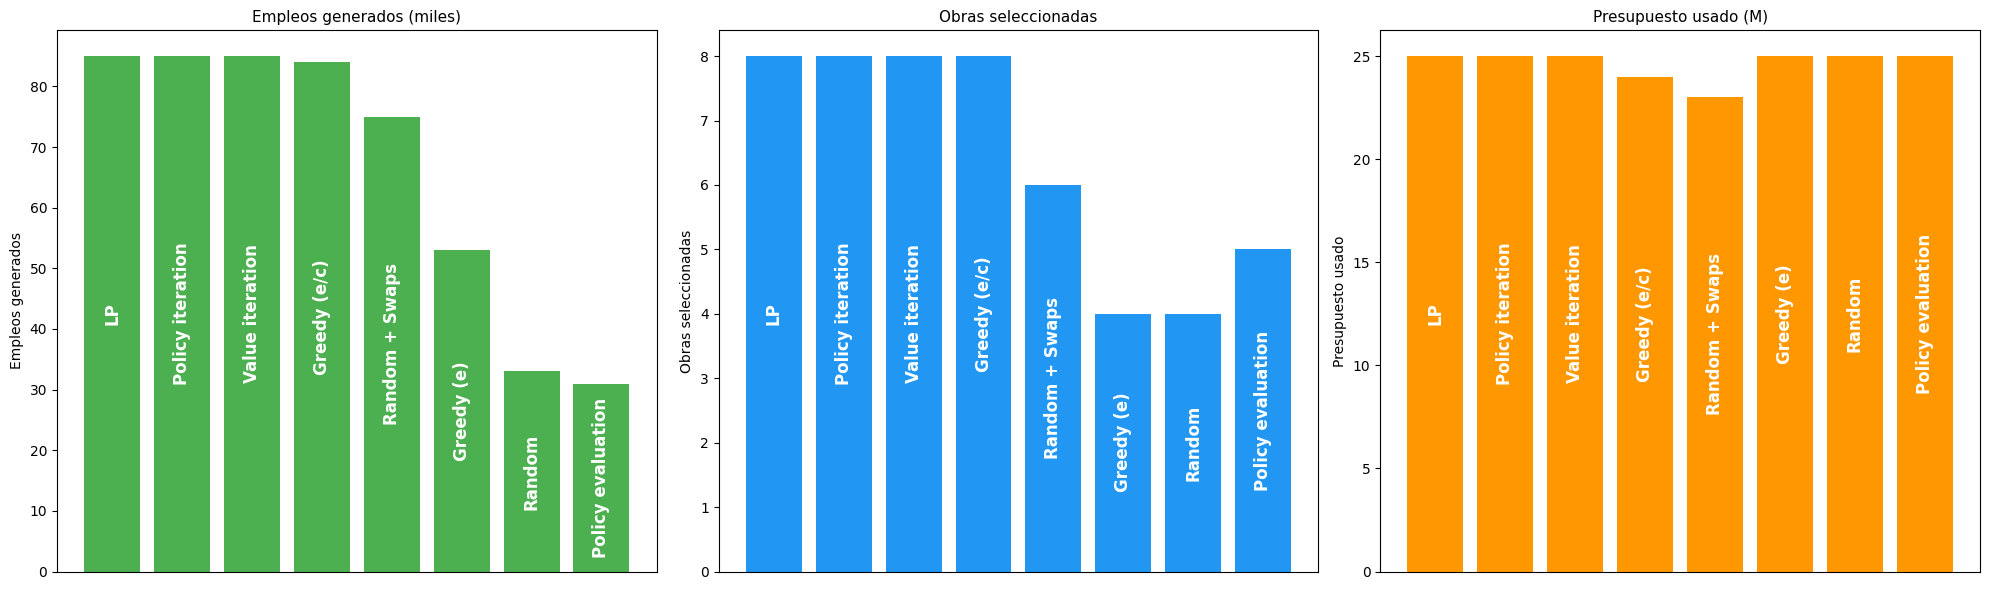

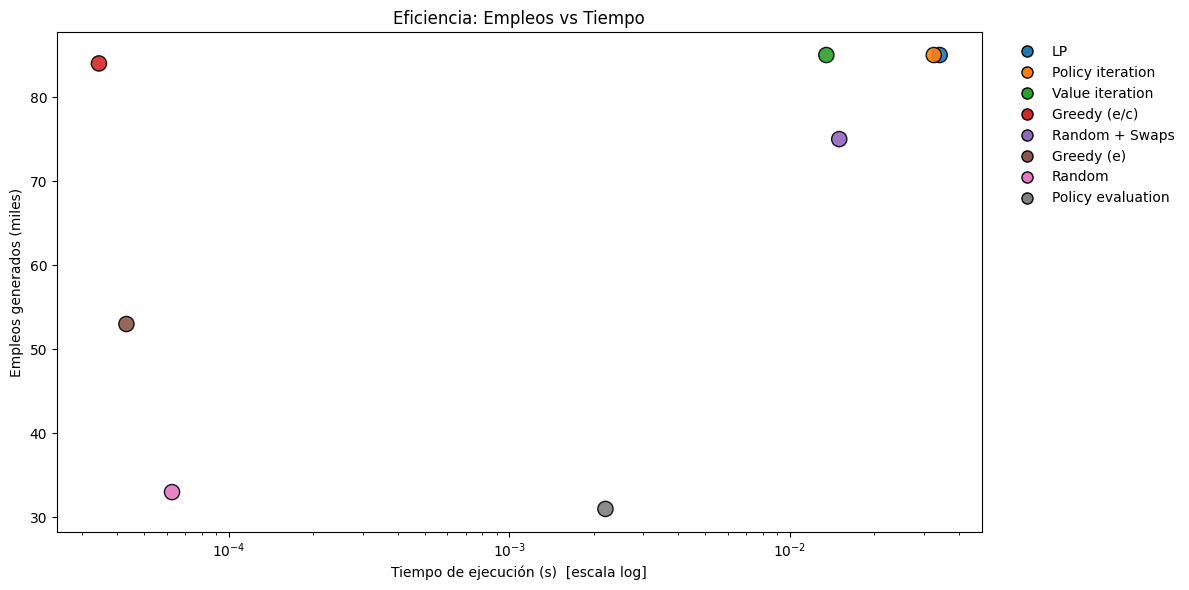

In [134]:
plot_barras_con_etiquetas(df_resultados)
plot_eficiencia(df_resultados)

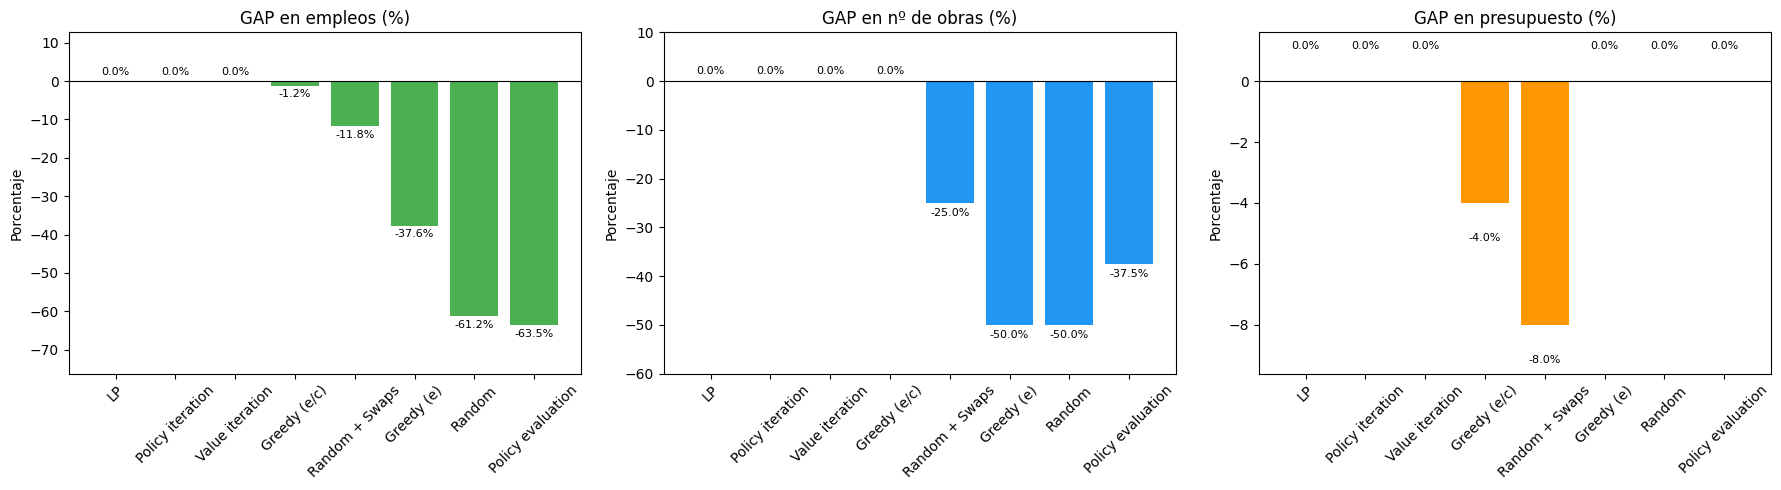

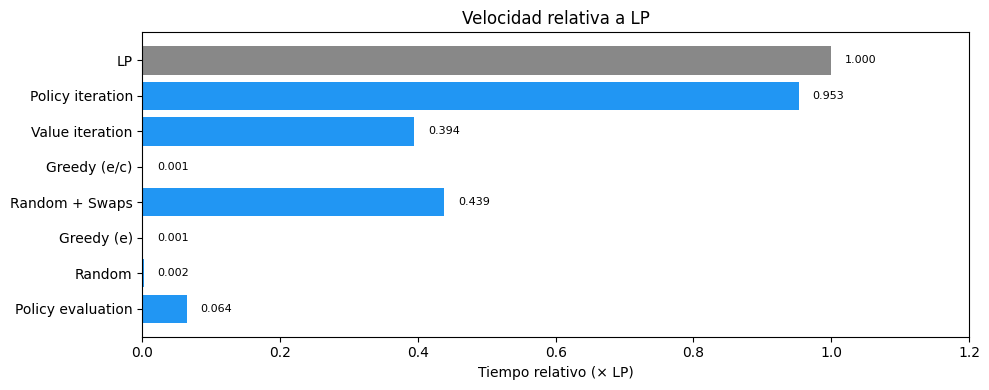

In [135]:
plot_gaps(gap_df)
plot_tiempo_relativo(gap_df)


## (Opcional) Visualizar PD

In [136]:
# ----- DESDE ACÁ EN ADELANTE, NO TOQUE EL CÓDIGO DE ESTÁ CELDA.

# Visualización  de V(s)
if env.capacity <= 20:

    # Evaluación de política
    print("Policy Evaluation")
    value_states_visual(env, V, propose_policy)

    # Política óptima vía iteración de políticas
    print("Policy Iteration")
    value_states_visual(env, V_star, star_policy)

    # Política óptima vía iteración de valores
    print("Value Iteration")
    value_states_visual(env, V_opt, opt_policy)

else:
    print("Para visualizar, use una instancia más pequeña.")

Para visualizar, use una instancia más pequeña.


In [137]:
# ----- DESDE ACÁ EN ADELANTE, NO TOQUE EL CÓDIGO DE ESTÁ CELDA.

# Visualización de las decisiones para cada política evaluada
if env.capacity <= 20:

    # Evaluación de política
    print("Policy Evaluation")
    draw_policy_dag(env, propose_policy, initial_state=(0, env.capacity))
    print()

    # Política óptima vía iteración de políticas
    print("Policy Iteration")
    draw_policy_dag(env, star_policy, initial_state=(0, env.capacity))
    print()

    # Política óptima vía iteración de valores
    print("Value Iteration")
    draw_policy_dag(env, opt_policy, initial_state=(0, env.capacity))
    print()

else:
    print("Para visualizar, use una instancia más pequeña.")


Para visualizar, use una instancia más pequeña.
